# Distribution Experiment - Walkthrough



In [31]:
import sys, os
# Insert path to model directory,.
cwd = os.getcwd()
path = f"{cwd}/../../src"
sys.path.insert(0, path)

import warnings
import tqdm
import random
import pandas as pd
import numpy as np
import argparse
from sklearn.utils import check_random_state

# toy datasets
from data.it_data import MIData

# Kernel Dependency measure
from models.dependence import HSIC
from models.kernel import estimate_sigma, sigma_to_gamma, gamma_to_sigma, get_param_grid

# RBIG IT measures
from models.ite_algorithms import run_rbig_models

# experiment helpers
from tqdm import tqdm

# Plotting Procedures
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_style("dark")
sns.set_context("poster")
warnings.filterwarnings('ignore') # get rid of annoying warnings
%matplotlib inline

warnings.filterwarnings('ignore') # get rid of annoying warnings

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Datasets

* Samples - [500, 1K, 5K, 10K, 30K, 50K]
* Dimensions - [ 2, 3, 10, 50, 100]
* trials - `1:5`
* IT measures - Mutual Information
* Distributions - [Gaussian, T-Student]

## Example Gaussian Distribution: 2D

In [3]:
# dataloader params
dataset = 'gauss'

# initialize dataloader
dataloader = MIData(dataset)

# dataset params
samples = 100
dimensions = 2
std = 1
trial = 1

# extract dataset
X, Y, mi_val = dataloader.get_data(samples=samples, dimensions=dimensions, std=std, trial=trial)

<Figure size 720x720 with 0 Axes>

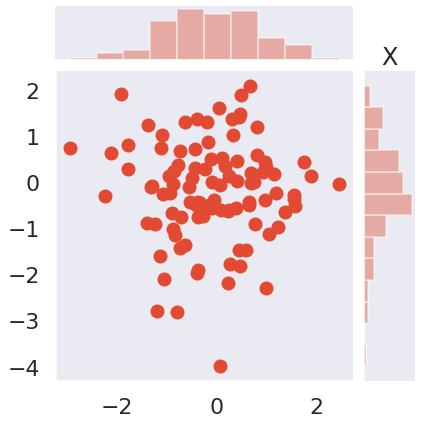

<Figure size 720x720 with 0 Axes>

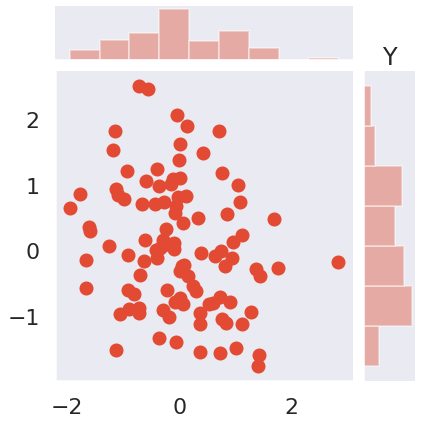

In [4]:
# plot data
fig  = plt.figure(figsize=(10, 10))

g = sns.jointplot(
    x=X[:, 0],
    y=X[:, 1],
)
plt.title('X')
plt.show()

# plot data
fig  = plt.figure(figsize=(10, 10))

g = sns.jointplot(
    x=Y[:, 0],
    y=Y[:, 1],
)
plt.title('Y')
plt.show()

## HSIC Algorithms

### HSIC

**algorithm path**: *src/models/dependence.py*

#### 1. Initialize Gamma

In [5]:
# sigma initialization params
percent = .2
method = 'belkin'

# initialize sigma
sigma_init_X = estimate_sigma(X, method=method, percent=percent)
sigma_init_Y = estimate_sigma(Y, method=method, percent=percent)

print(f'Sigma_x: ', sigma_init_X)
print(f'Sigma_y: ', sigma_init_Y)

Sigma_x:  0.9583709525127224
Sigma_y:  0.8719893561231888


#### 1.1 Mean of Initial sigmas

In [6]:
sigma_init = np.mean([sigma_init_X, sigma_init_Y])

print(f'Sigma_init (Belkin): ', sigma_init)

Sigma_init (Belkin):  0.9151801543179556


#### 1.3 Convert Gamma to Sigma

The standard kernel function is:

$$K(x,y)= \exp(-\frac{||x-y||^2}{2\sigma^2})$$

Sklearn uses the following RBF kernel function:

$$K(x,y)= \exp(-\gamma||x-y||^2)$$

So the following relationship is:

$$\gamma = \frac{1}{2\sigma^2}$$

In [7]:
# convert sigma to gamma
gamma_init = sigma_to_gamma(sigma_init)

# check if true
assert(gamma_init == 1 / (2 * sigma_init ** 2))

print('Gamma_init (Belkin):', gamma_init)

Gamma_init (Belkin): 0.5969759242357159


### 1.4 Create Function

In [8]:
from typing import Optional

def get_gamma_init(X: np.ndarray, Y: np.ndarray, method: str, percent: Optional[float]=None) -> float:
    """Get Gamma initializer
    
    Parameters
    ----------
    method : str,
        the initialization method
        
    percent : float
        if using the Belkin method, this uses a percentage
        of the kth nearest neighbour
    
    Returns
    -------
    gamma_init : float
        the initial gamma value
    """
    
    # initialize sigma
    sigma_init_X = estimate_sigma(X, method=method, percent=percent)
    sigma_init_Y = estimate_sigma(Y, method=method, percent=percent)

    # mean of the two
    sigma_init = np.mean([sigma_init_X, sigma_init_Y])
    
    # convert sigma to gamma
    gamma_init = sigma_to_gamma(sigma_init)
    
    # return initial gamma value
    return gamma_init

#### 4. Calculate HSIC


In [9]:
# hsic parameters
kernel = 'rbf'
scorer = 'hsic'
subsample = None 
bias = True

# initialize HSIC model
clf_hsic = HSIC(
    gamma=gamma_init,
    kernel=kernel,
    scorer=scorer,
    subsample=subsample,
    bias=bias
)

# fit model to data
clf_hsic.fit(X, Y)

# get hsic value
hsic_value = clf_hsic.score(X)

print('HSIC: ', hsic_value)

HSIC:  0.004420621559606378


In [10]:
def get_hsic(X: np.ndarray, Y: np.ndarray, scorer: str, gamma_init: float) -> float:
    """Gets the HSIC parameters
    
    Parameters
    ----------
    X : np.ndarray, (n_samples, d_dimensions)
        1st input array 
    
    Y : np.ndarray, (n_samples, d_dimensions)
        2nd input array
    
    scorer : str, 
        the scorer to calculate the hsic
        * hsic - HSIC method
        * tka  - kernel tangent alignment
        * ctka - centered kernel tangent alignment
        
    gamma_init : float
        the initial gamma parameter
    
    Returns
    -------
    hsic_value : float
        the hsic value calculated from the scorer
    """
    # hsic parameters
    kernel = 'rbf'
    subsample = None 
    bias = True

    # initialize HSIC model
    clf_hsic = HSIC(
        gamma=gamma_init,
        kernel=kernel,
        scorer=scorer,
        subsample=subsample,
        bias=bias
    )

    # fit model to data
    clf_hsic.fit(X, Y)

    # get hsic value
    hsic_value = clf_hsic.score(X)
    
    return hsic_value

## Experiment I - Different Scorers

We are looking at different "HSIC scorers". They are:

---
**HSIC**

$$HSIC = \frac{1}{n(n-1)}\langle K_xH,K_yH \rangle_F$$

Notice: we have the centered kernels, $K_xH$ and no normalization.

---
**TKA** 

$$TKA = \frac{\langle K_x,K_y \rangle_F}{||K_x||_F||K_y||_F}$$

Notice: We have the uncentered kernels and a normalization factor.

---
**cTKA**

$$cTKA = \frac{\langle K_xH,K_yH \rangle_F}{||K_xH||_F||K_yH||_F}$$

Notice: We have the centered kernels and a normalization factor.

In [11]:
# experimental parameters
method = 'belkin'
percent = 0.2

hsic_values = dict()


for iscorer in ['hsic', 'tka', 'ctka']:
    
    # get initial gamma
    gamma_init = get_gamma_init(X, Y, method, percent)
    
    # get HSIC value
    hsic_values[iscorer] = get_hsic(X, Y, iscorer, gamma_init)
    
print(hsic_values)

{'hsic': 0.004420621559606378, 'tka': 0.543442521262865, 'ctka': 0.06751049509744558}


## Experiment II - Different Scorers, Initializers

In [12]:
# dataset params
dataset = 'gauss'
samples = 100
dimensions = 2
std = 1
trial = 1

# extract dataset
X, Y, mi_val = MIData(dataset).get_data(samples=samples, dimensions=dimensions, std=std, trial=trial)

# experimental parameters
scorers = ['hsic', 'tka', 'ctka']
gamma_methods = [
    ('silverman',None),
    ('scott', None),
    ('median', None),
    ('belkin', 0.1),
    ('belkin', 0.2),
    ('belkin', 0.4),
    ('belkin', 0.8),
]

# results dataframe
results_df = pd.DataFrame()


# run experiment
for iscorer in scorers:
    for imethod in gamma_methods:
        
        # initialize gamma
        gamma_init = get_gamma_init(X, Y, imethod[0], imethod[1])
        
        # get hsic_value
        hsic_value = get_hsic(X, Y, iscorer, gamma_init)
        
        # append results to dataframe
        results_df = results_df.append({
            'scorer': iscorer,
            'gamma_method': f"{imethod[0]}_{imethod[1]}" if imethod[1] is not None else f"{imethod[0]}",
            'gamma_init': gamma_init,
            'hsic_value': hsic_value
        }, ignore_index=True)
        
results_df.head()

,gamma_init,gamma_method,hsic_value,scorer
0,2.320794,silverman,0.008088,hsic
1,2.320794,scott,0.008088,hsic
2,0.185138,median,0.001182,hsic
3,1.239664,belkin_0.1,0.006772,hsic
4,0.596976,belkin_0.2,0.004421,hsic


In [13]:
# plot the results

def plot_scorer(scorer:str)-> None:
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

    sns.scatterplot(
        x='gamma_init', 
        y='hsic_value',
        hue='gamma_method',
        data=results_df[results_df['scorer'] == scorer],
        ax=ax
    )
    ax.set_ylabel('Score')
    ax.set_xlabel('Gamma Initialization')
    ax.legend(prop={'size':9})
    ax.set_title(scorer.upper())
    plt.show()

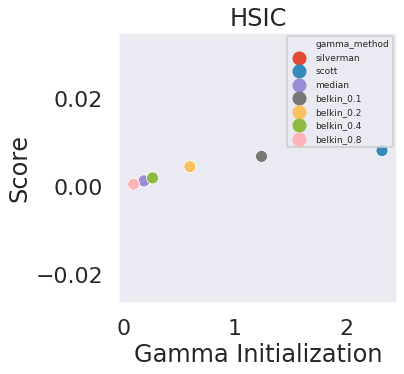

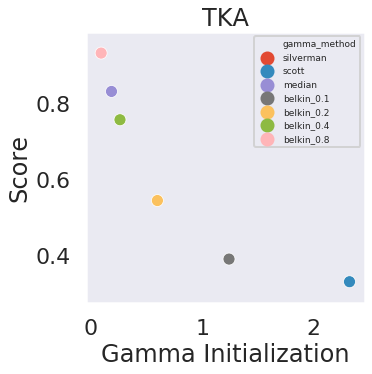

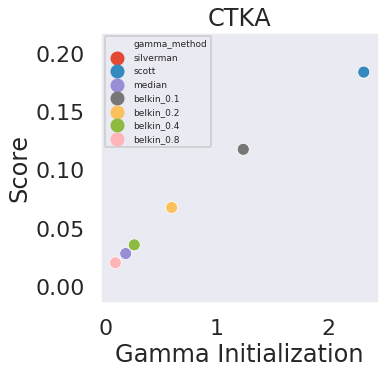

In [14]:
plot_scorer('hsic')
plot_scorer('tka')
plot_scorer('ctka')

## Experiment II - Different Scorers, Initializations and Degree of Freedom

In this experiment, we'll be looking at how do the HSIC values change depending upon the gamma initialization as well as the degree of freedom we choose. In the Gaussian distribution, this is the standard deviation, $\sigma$ and the T-Student distribution this is the $\nu$ parameter.

In [17]:
from tqdm import trange, tqdm

In [21]:
# dataset params
dataset = 'gauss'
samples = 100
dimensions = 2
std = 1
trial = 1



# experimental parameters
scorers = ['hsic', 'tka', 'ctka']
gamma_methods = [
    ('silverman',None),
    ('scott', None),
    ('median', None),
    ('belkin', 0.1),
    ('belkin', 0.2),
    ('belkin', 0.4),
    ('belkin', 0.8),
]
dof_params = np.linspace(1,11, 11, endpoint=True)

# results dataframe
results_df = pd.DataFrame()


# run experiment
with tqdm(gamma_methods) as gamma_bar:
    for imethod in gamma_bar:
        for iscorer in scorers:
            for idof in dof_params:

                # extract dataset
                X, Y, mi_val = MIData(dataset).get_data(samples=samples, dimensions=dimensions, std=int(idof), trial=trial)

                # initialize gamma
                gamma_init = get_gamma_init(X, Y, imethod[0], imethod[1])

                # get hsic_value
                hsic_value = get_hsic(X, Y, iscorer, gamma_init)

                # append results to dataframe
                results_df = results_df.append({
                    'scorer': iscorer,
                    'gamma_method': f"{imethod[0]}_{imethod[1]}" if imethod[1] is not None else f"{imethod[0]}",
                    'gamma_init': gamma_init,
                    'hsic_value': hsic_value,
                    'std': idof,
                    'mi_value': mi_val,
                }, ignore_index=True)

results_df.head()

100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


,gamma_init,gamma_method,hsic_value,mi_value,scorer,std
0,2.320794,silverman,0.008088,0.000000,hsic,1.0
1,2.320794,silverman,0.008068,0.002053,hsic,2.0
2,2.320794,silverman,0.008096,0.007718,hsic,3.0
3,2.320794,silverman,0.008163,0.016467,hsic,4.0
4,2.320794,silverman,0.008259,0.027999,hsic,5.0


In [22]:
# plot the results

def plot_scorer_mi(df: pd.DataFrame, scorer:str)-> None:
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

    sns.scatterplot(
        x='hsic_value', 
        y='mi_value',
        hue='gamma_method',
        data=df[df['scorer'] == scorer],
        ax=ax
    )
    ax.set_ylabel('Mutual Information')
    ax.set_xlabel('HSIC Score')
    ax.legend(prop={'size':9})
    ax.set_title(scorer.upper())
    plt.show()

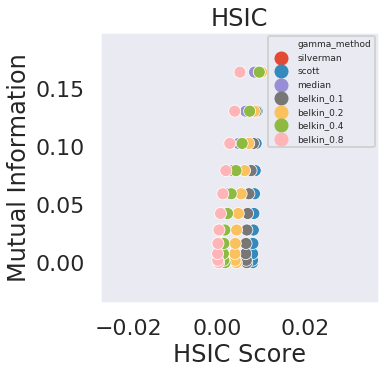

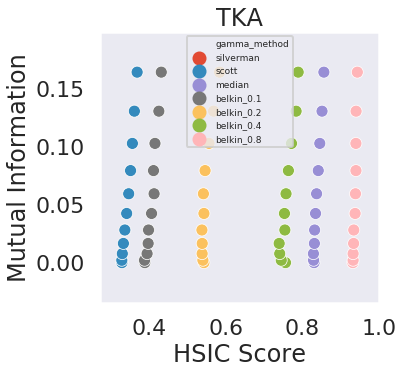

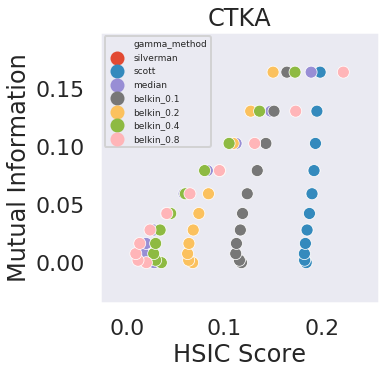

In [23]:
plot_scorer_mi(results_df, 'hsic')
plot_scorer_mi(results_df, 'tka')
plot_scorer_mi(results_df, 'ctka')

### Same Experiment, but with a higher number of samples and dimensions

In [25]:
# dataset params
dataset = 'gauss'
samples = 5_000
dimensions = 50
std = 1
trial = 1



# experimental parameters
scorers = ['hsic', 'tka', 'ctka']
gamma_methods = [
    ('silverman',None),
    ('scott', None),
    ('median', None),
    ('belkin', 0.1),
    ('belkin', 0.2),
    ('belkin', 0.4),
    ('belkin', 0.8),
]
dof_params = np.linspace(1,11, 11, endpoint=True)

# results dataframe
results_df = pd.DataFrame()


# run experiment
with tqdm(gamma_methods) as gamma_bar:
    for imethod in gamma_bar:
        for iscorer in scorers:
            for idof in dof_params:
        
                # extract dataset
                X, Y, mi_val = MIData(dataset).get_data(samples=samples, dimensions=dimensions, std=int(idof), trial=trial)

                # initialize gamma
                gamma_init = get_gamma_init(X, Y, imethod[0], imethod[1])

                # get hsic_value
                hsic_value = get_hsic(X, Y, iscorer, gamma_init)

                # append results to dataframe
                results_df = results_df.append({
                    'scorer': iscorer,
                    'gamma_method': f"{imethod[0]}_{imethod[1]}" if imethod[1] is not None else f"{imethod[0]}",
                    'gamma_init': gamma_init,
                    'hsic_value': hsic_value,
                    'std': idof,
                    'mi_value': mi_val,
                }, ignore_index=True)

results_df.head()

100%|██████████| 7/7 [12:52<00:00, 110.41s/it]


,gamma_init,gamma_method,hsic_value,mi_value,scorer,std
0,0.753748,silverman,0.0002,0.000000,hsic,1.0
1,0.753748,silverman,0.0002,0.321973,hsic,2.0
2,0.753748,silverman,0.0002,0.539285,hsic,3.0
3,0.753748,silverman,0.0002,0.715096,hsic,4.0
4,0.753748,silverman,0.0002,0.885865,hsic,5.0


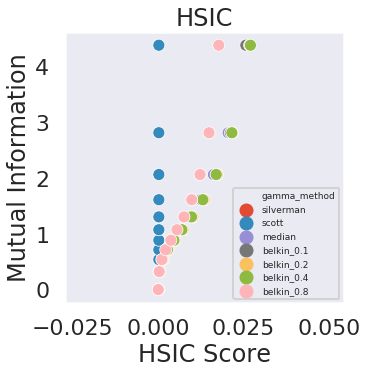

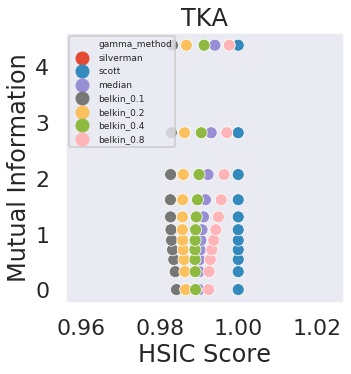

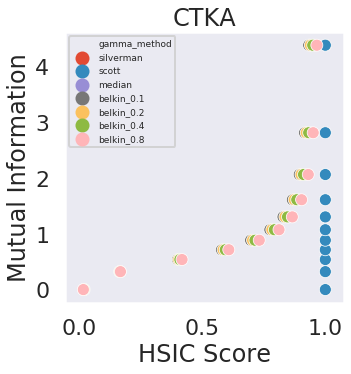

In [32]:
plot_scorer_mi(results_df, 'hsic')
plot_scorer_mi(results_df, 'tka')
plot_scorer_mi(results_df, 'ctka')